In [739]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from functools import partial
from IPython.core.display import display, HTML
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

# Data Engineering

## Data discovery

In [740]:
#inspecting column names and data types;
bikes_df = pd.read_csv('SeoulBikeData.csv')
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [741]:
#showing first 5 rows of data
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


There are no missing values in any of the columns. Some Object data types can be adjusted for easier handling, e.g. "Date" changed into a Datetime object, "Holiday" and "Functioning Day" changed into Boolean after confirming they hold two unique values.

In [742]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [743]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [744]:
#summary of the dataset
bikes_df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


The dataset includes rented bike counts from Dec 1st. 2017 to Nov. 30th 2018. The data is provided for every hour of the day, along with weather information including Temperature, Humidity, Wind Speed and Rainfall. It also describes the Season of the year for every entry and indicates whether it was a holiday or not. The bike renting service was not always available, which is described by the Functioning Day column.

The dataset consists of 8760 entries in total. The mean bike count rent is 705 rents per hour, while the median amounts to 505 rents. This difference is most likely linked to outliers with unusually high counts of bike rents. This is further reinforced by checking the min/max values for the rented bike count, which are 0 and 3556 respectively.

The average year temperature amounts to 12.9 degrees Celsius with a median of 13.7.

An interesting observation can be made with Rainfall and Snowfall features - while they have a relatively low mean values (1.1 mm and 0.4 mm respectively), their median values are both at 0. This essentially means that over 50% of the time (measured in hours) there were no rain- or snowfalls. With that in mind, it stands to question whether these features shouldn't be boolean and signify whether it was raining or not during the given hour of a day. This might simplify any models built within this exercise without affecting their accuracy.

## Data Cleanup

Since both Holiday and Functioning Day features include only 2 unique values each, turning their data type into boolean will make further data processing more efficient. The Date feature will be turned a proper Datetime type along the way.

In [745]:
#changing Date feature into Datetime
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")

#changing Holiday feature into Boolean
bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
bikes_df.loc[bikes_df['Holiday'] == 'No Holiday', 'Holiday'] = 0
bikes_df['Holiday'] = bikes_df['Holiday'].astype(bool, copy=False)

#changing Functioning Day feature into Boolean
bikes_df.loc[bikes_df['Functioning Day'] == 'No', 'Functioning Day'] = 0
bikes_df.loc[bikes_df['Functioning Day'] == 'Yes', 'Functioning Day'] = 1
bikes_df['Functioning Day'] = bikes_df['Functioning Day'].astype(bool, copy=False)

# changing rainfall and snowfall features into one boolean feature: Precipitation
bikes_df['Precipitation'] = 0
bikes_df.loc[bikes_df['Rainfall(mm)'] != 0, 'Precipitation'] = 1
bikes_df.loc[bikes_df['Snowfall (cm)'] != 0, 'Precipitation'] = 1

bikes_df.rename(inplace=True, columns={'Rented Bike Count':'RentedBikeCount', 'Wind speed (m/s)':'WindSpeed(m/s)','Visibility (10m)':'Visibility(10m)','Solar Radiation (MJ/m2)':'SolarRadiation(MJ/m2)','Snowfall (cm)':'Snowfall(cm)'})

#checking the data types after changes
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   RentedBikeCount           8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   WindSpeed(m/s)            8760 non-null   float64       
 6   Visibility(10m)           8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   SolarRadiation(MJ/m2)     8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall(cm)              8760 non-null   float64       
 11  Seasons                   8760 non-null   object        
 12  Holiday             

# Exploratory Data Analysis

## Data distributions

To get a visual idea of the data distributions, we plotted histograms, violin plots and bar plots below for all features except for the Date, Hour, Month, Holiday and Functioning Day features.

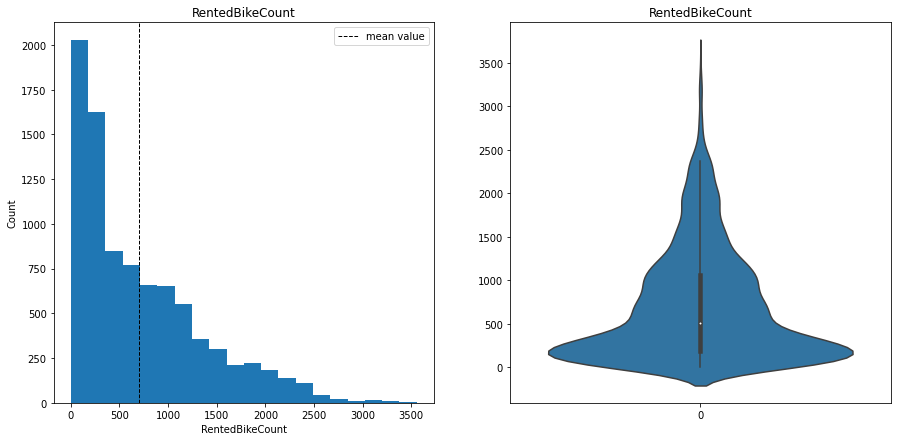

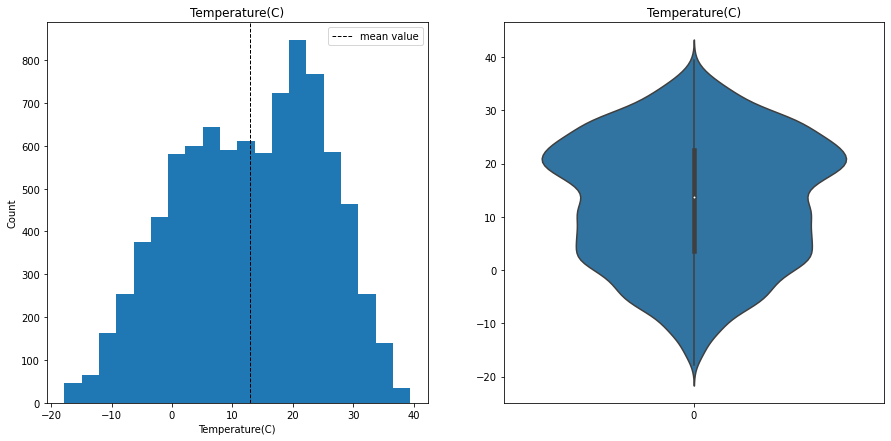

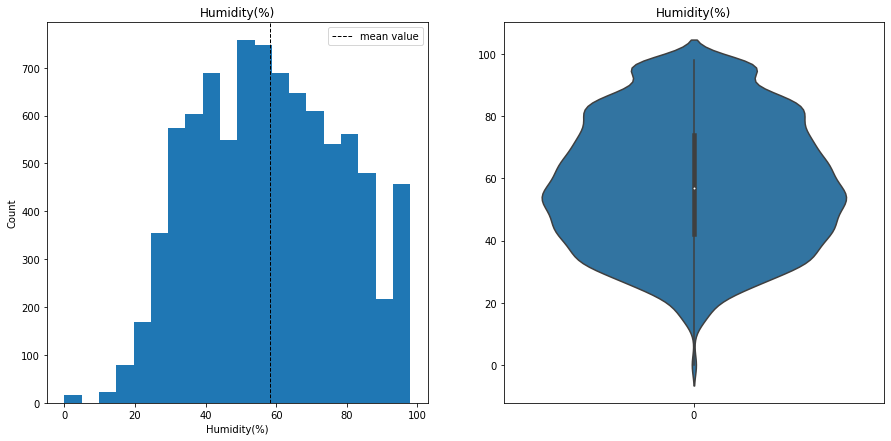

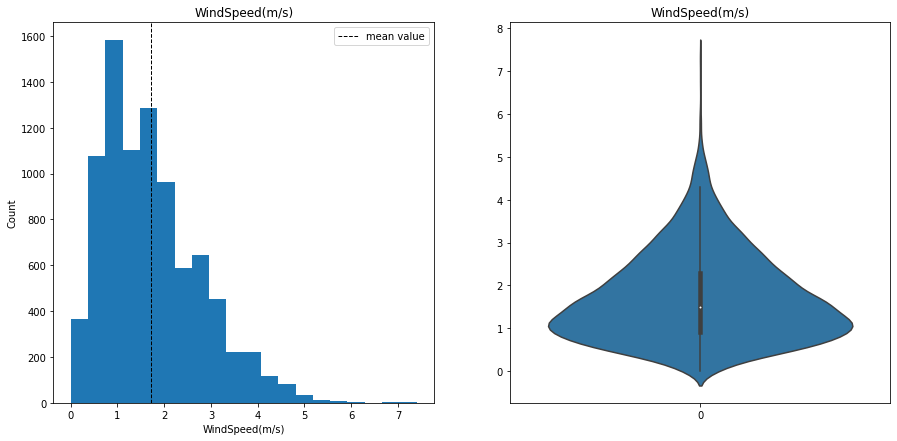

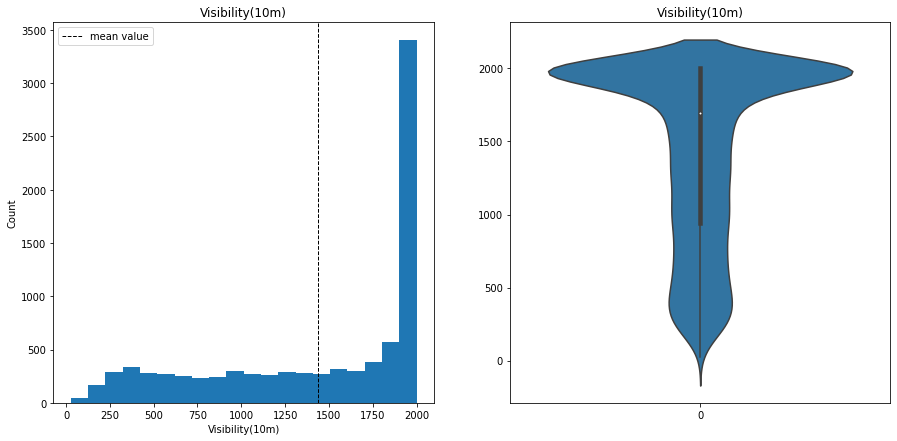

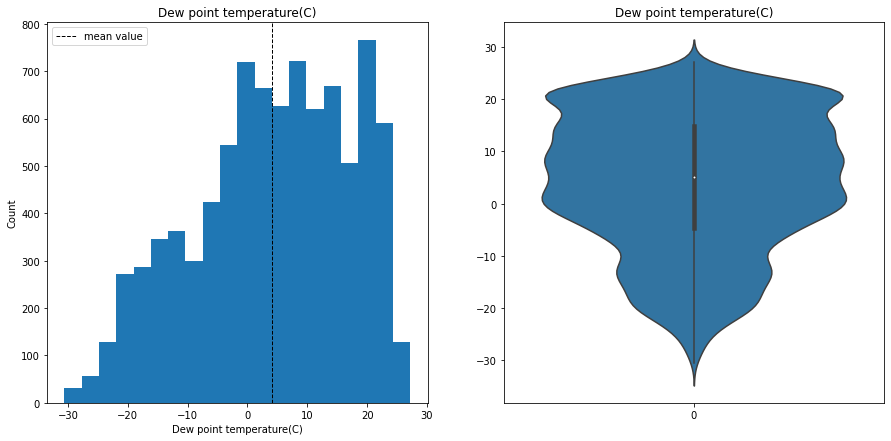

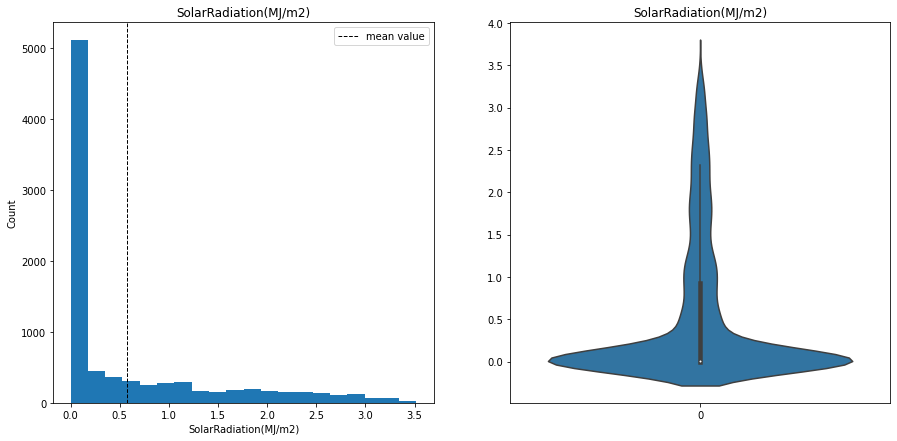

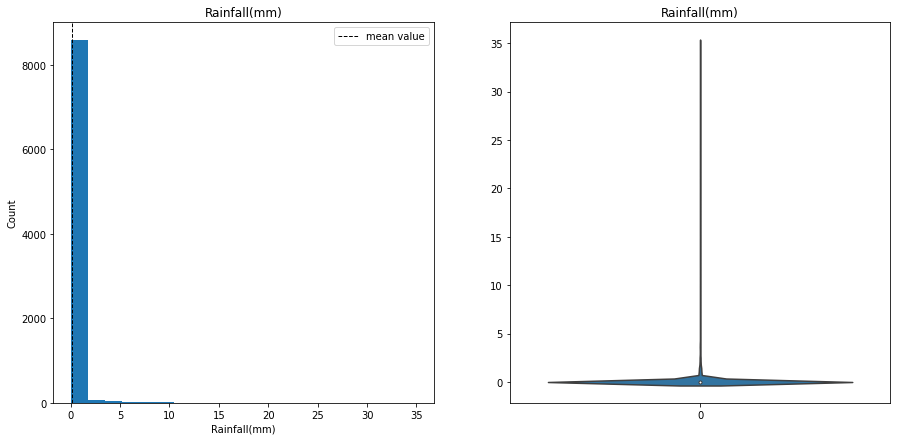

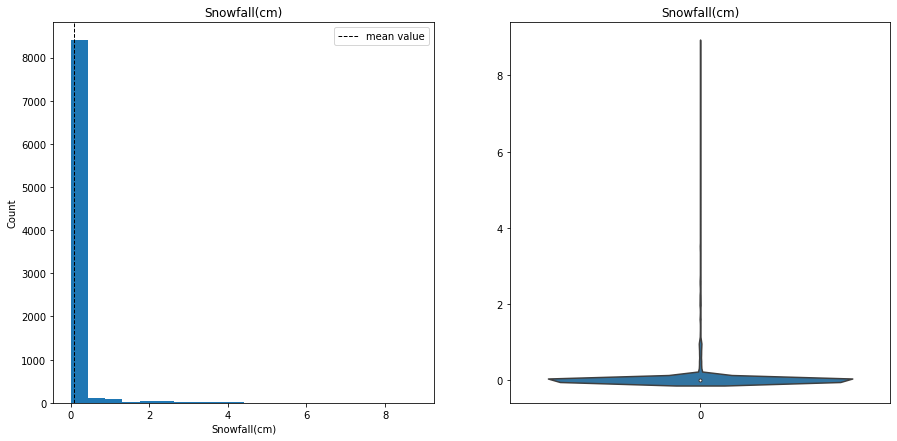

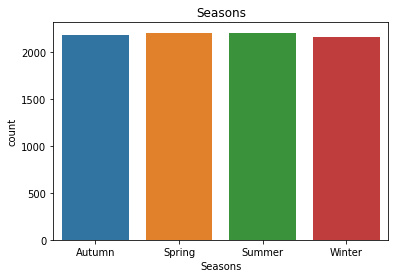

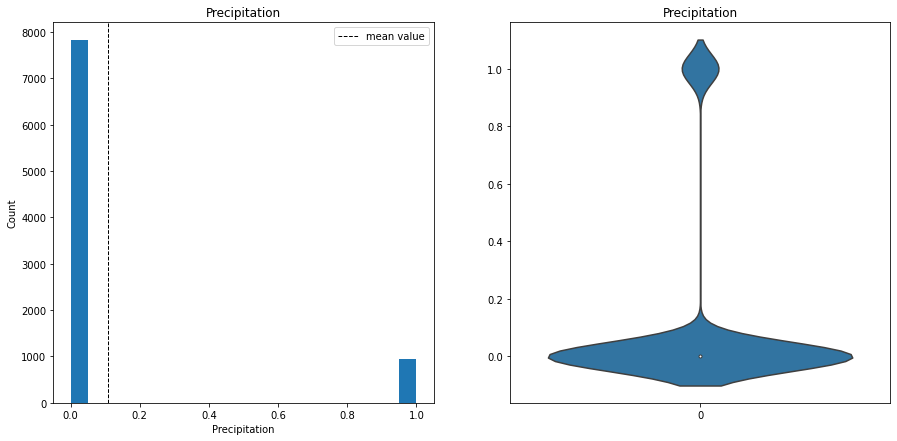

In [746]:
for i in bikes_df.columns:
    if i in ['Date', 'Hour', 'Month'] or bikes_df[i].dtype == 'bool':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,2,1)
        plt.figure
        plt.hist(bikes_df[i], bins=20)
        plt.axvline(bikes_df[i].mean(), color='k', linestyle='dashed', linewidth=1, label='mean value')
        plt.legend()
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        ax = plt.subplot(1,2,2)
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Rented bike count is right skewed and far from a normal distribution, as the values are concentrated around lower numbers of bike rents. The mean bike count rent per hour is around 700, while the median per hour bike rent count is around 500.<br />
Temperature is much closer to a normal distribution, although it is slightly left skewed. The mean temperature amounts to around 13 degrees Celsius, while the median is slightly higher at around 14 degrees. It is worth noting that Dew Point temperature appears to be distributed in a much similar fashion to Temperature, implying a close correlation.<br />
Humidity is normally distributed with mean humidity at 58% and the median at 57%.<br />
Wind speed, rainfall, snowfall and solar radiation are heavily right skewed, which is expected, as the high values can go to large extremes and form a long tail of outliers on the graphs. Similarly to the Visibity feature except that it is heavily left skewed.<br />
Seasons box plot is expected to show almost equal counts for all the seasons. The neglibigle differences coming from the fact that the seasons do not share the exact same number of days.




In [747]:
#checking number of days per season
rent_season_group = bikes_df[['Seasons','Holiday']].groupby(['Seasons']).apply(lambda x: x['Holiday'].count() / 24).reset_index()
rent_season_group.rename(inplace=True, columns={0:'Days'})
rent_season_group

,Seasons,Days
0,Autumn,91.0
1,Spring,92.0
2,Summer,92.0
3,Winter,90.0


The rented bike count histogram presented the data as is, i.e. displayed the counts for every hour throughout the year. Let's agggregate the same data on a per day basis, to get an overview of counts distribution for entire days.

In [748]:
rent_day_group = bikes_df[['Date', 'RentedBikeCount']].groupby(['Date']).sum()

rent_day_group['RentedBikeCount']
rent_day_group.max()
rent_day_group.head()

,RentedBikeCount
Date,
2017-12-01,9539
2017-12-02,8523
2017-12-03,7222
2017-12-04,8729
2017-12-05,8307


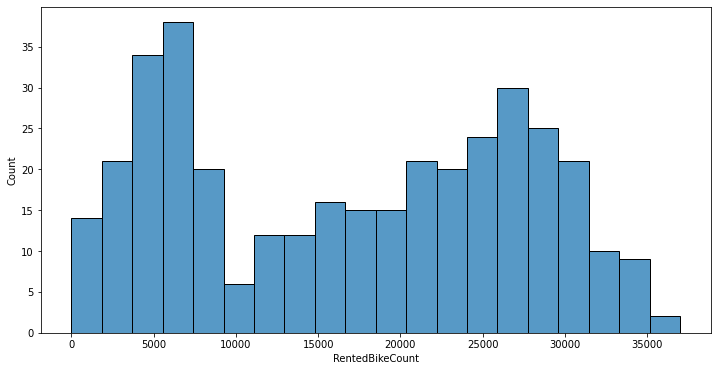

In [749]:
plt.figure(figsize=(12,6))
sns.histplot(data=rent_day_group, x='RentedBikeCount',bins=20, binrange=(0,37000))
plt.show()

The histogram has a significantly different shape then the one created for per hour bike counts. Let's see whether the shape is correlated with bike rent counts for different seasons.

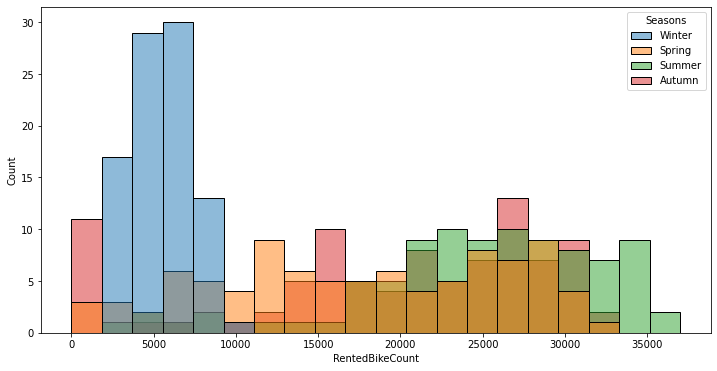

<Figure size 432x288 with 0 Axes>

In [750]:
rent_season_group = bikes_df[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
plt.figure(figsize=(12,6))
sns.histplot(data=rent_season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()


It is interesting to note that the shape of the histogram changed significantly for most of the bins except for the 0-1000 range which appears largely unchanged. This range is dominated by Winter readings and that is why when doing a distribution per Season, this block is almost the same as for the per day distribution. We should expect the remaining of the year to regain its previous shape, when we treat the remaining seasons (spring, summer and autumn) as one.

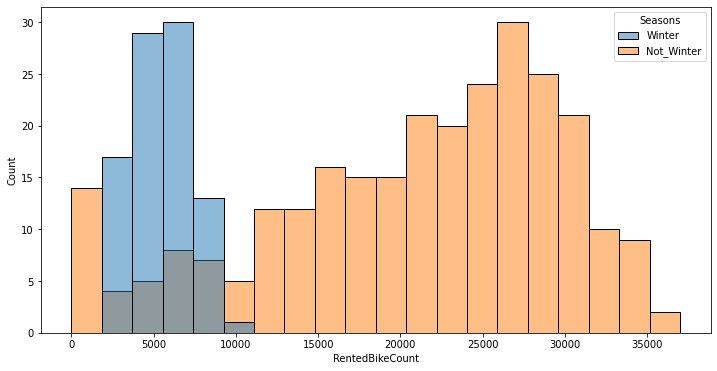

<Figure size 432x288 with 0 Axes>

In [751]:
rent_2season_group = pd.DataFrame(rent_season_group.reset_index())
#bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
rent_2season_group.loc[rent_2season_group['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'
plt.figure(figsize=(12,6))
sns.histplot(data=rent_2season_group, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.show()
plt.clf()


To understand the data better we might want to exclude the days where the service was not functioning and see the data distribution again:


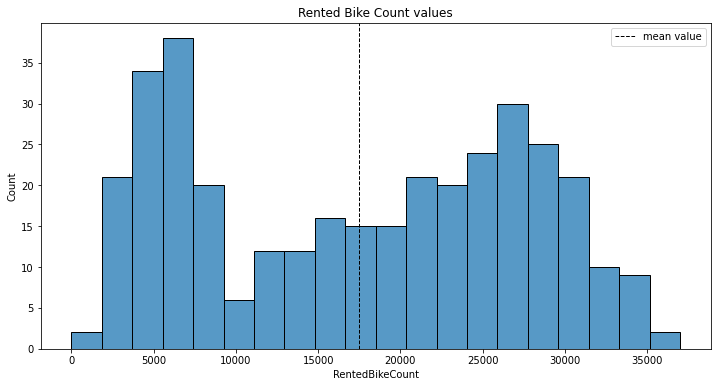

<Figure size 432x288 with 0 Axes>

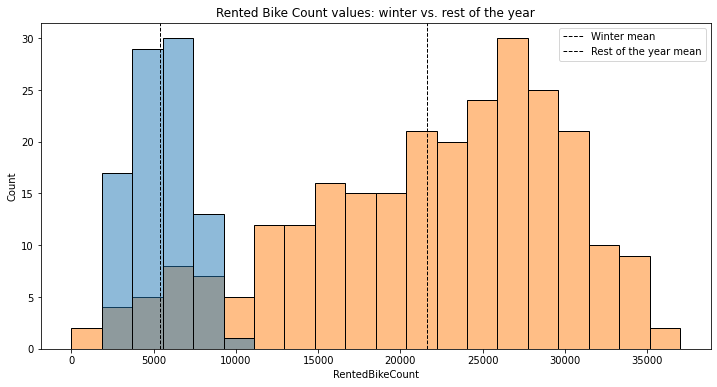

<Figure size 432x288 with 0 Axes>

In [752]:
bikes_df_only_functioning = bikes_df[bikes_df['Functioning Day'] == True]
rent_day_group_only_functioning = bikes_df_only_functioning[['Date', 'RentedBikeCount']].groupby(['Date']).sum()

plt.figure(figsize=(12,6))
sns.histplot(data=rent_day_group_only_functioning, x='RentedBikeCount',bins=20,binrange=(0,37000))
plt.axvline(rent_day_group_only_functioning['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1, label='mean value')
plt.legend()
plt.title('Rented Bike Count values')
plt.show()
plt.clf()

rent_season_group_only_functioning = bikes_df_only_functioning[['Date', 'Seasons','RentedBikeCount']].groupby(['Date', 'Seasons']).sum()
rent_2season_group_only_functioning = pd.DataFrame(rent_season_group_only_functioning.reset_index())
rent_2season_group_only_functioning.loc[rent_2season_group_only_functioning['Seasons'] != 'Winter', 'Seasons'] = 'Not_Winter'
plt.figure(figsize=(12,6))
sns.histplot(data=rent_2season_group_only_functioning, x='RentedBikeCount', hue='Seasons',bins=20,binrange=(0,37000))
plt.axvline(rent_2season_group_only_functioning[rent_2season_group_only_functioning['Seasons'] == 'Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1, label='Winter mean')
plt.axvline(rent_2season_group_only_functioning[rent_2season_group_only_functioning['Seasons'] == 'Not_Winter']['RentedBikeCount'].mean(), color='k', linestyle='dashed', linewidth=1, label='Rest of the year mean')
plt.legend()
plt.title('Rented Bike Count values: winter vs. rest of the year')
plt.show()
plt.clf()



The bike rent count distribution is apparently significantly different in Winter than in other months of the year.


In [753]:
# as shown in data distributions, we can bin the Seasons data into two categories: winter and the rest of the year
bikes_df['IsWinter'] = 1
bikes_df.loc[bikes_df['Seasons'] != 'Winter', 'IsWinter'] = 0

## Rented Bike Count Fluctuations Across the Year

To get an overview of the bike renting service, we created a few plots below to demonstrate the trends across different months and their possible link with temperatures and rainfalls.

In [754]:
#creating the "Month" column
bikes_df['Month'] = pd.DatetimeIndex(bikes_df['Date']).month
months_names =['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_nums = range(12)
def month_insert(x):
    return months_names[x-1]
bikes_df['Month'] = bikes_df['Month'].apply(month_insert)

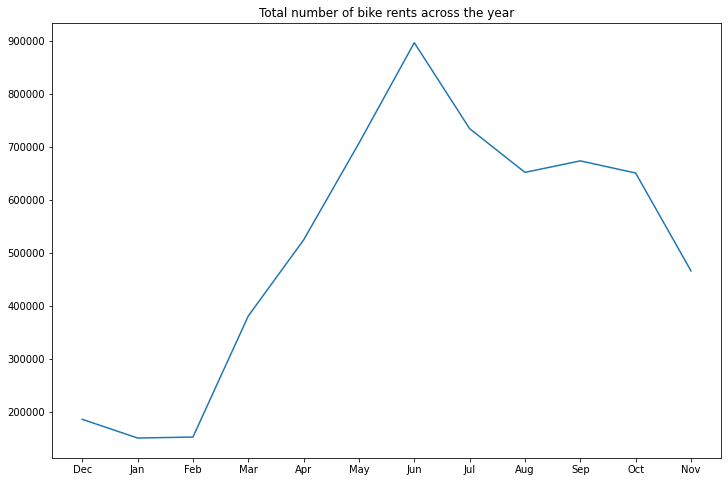

In [755]:
rent_month_group = bikes_df[['Month','RentedBikeCount']].groupby(['Month'], sort=False).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rent_month_group['Month'], rent_month_group['RentedBikeCount'])
#plt.axis([1,12, 120000, 950000])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.title('Total number of bike rents across the year')

plt.show()

The total number of bike rents is the lowest in December, January and February and peaks in June. This appears to be slightly correlated by rainfall (note how the rainfall was relatively low in June compared to May and July, August) and closely correlated with the mean month temperature (see plots below).

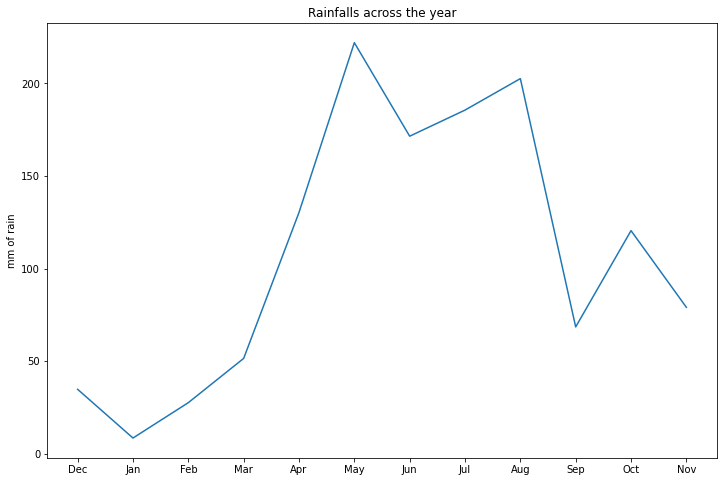

In [756]:
rainfall_month_group = bikes_df[['Month','Rainfall(mm)']].groupby(['Month'], sort=False).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rainfall_month_group['Month'], rainfall_month_group['Rainfall(mm)'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.title('Rainfalls across the year')
plt.ylabel('mm of rain')
plt.show()


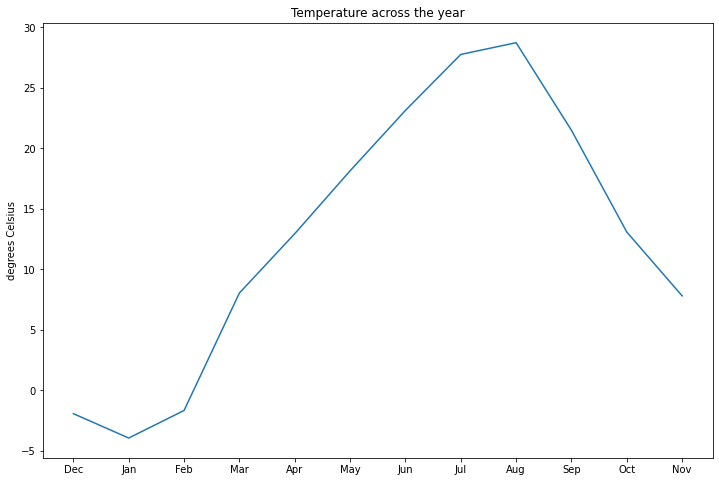

In [757]:
temperature_month_group = bikes_df[['Month','Temperature(C)']].groupby(['Month'],sort=False).mean().reset_index()
plt.figure(figsize=(12,8))
plt.plot(temperature_month_group['Month'], temperature_month_group['Temperature(C)'])
plt.xticks(month_nums, labels=([months_names[-1]]+months_names[:-1]))
plt.title('Temperature across the year')
plt.ylabel('degrees Celsius')
plt.show()

With a relatively good understanding of the data at hand, we may proceed to analyze data correlations and see if our initial conclusions are backed by data science.

## Rented Bike Count Fluctuations Across the Week

In [758]:
bikes_df['WeekDay']=bikes_df['Date'].dt.day_name()
mapping_dictDay={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
bikes_df['WeekDayEncoding']=bikes_df['WeekDay'].map(mapping_dictDay)
bikes_df.head()

,Date,RentedBikeCount,Hour,Temperature(C),Humidity(%),WindSpeed(m/s),Visibility(10m),Dew point temperature(C),SolarRadiation(MJ/m2),Rainfall(mm),Snowfall(cm),Seasons,Holiday,Functioning Day,Precipitation,IsWinter,Month,WeekDay,WeekDayEncoding
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,False,True,0,1,Dec,Friday,5
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,False,True,0,1,Dec,Friday,5
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,False,True,0,1,Dec,Friday,5
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,False,True,0,1,Dec,Friday,5
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,False,True,0,1,Dec,Friday,5


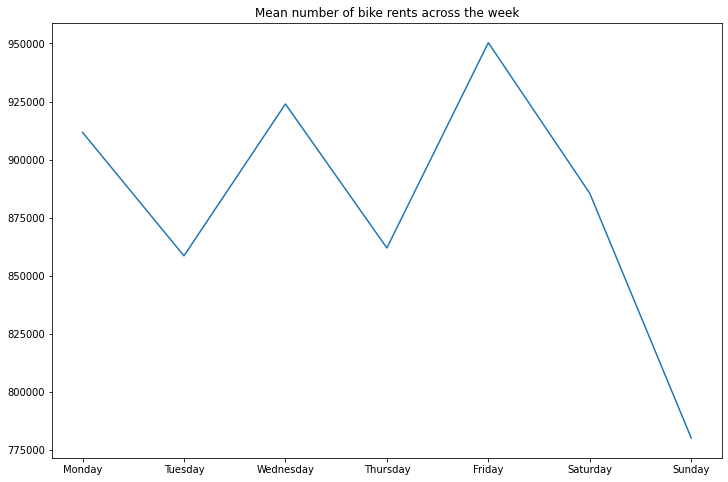

In [759]:
rent_weekday_group = bikes_df[['WeekDayEncoding','RentedBikeCount']].groupby(['WeekDayEncoding'], sort=True).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rent_weekday_group['WeekDayEncoding'], rent_weekday_group['RentedBikeCount'])

plt.xticks(range(1,8), labels=mapping_dictDay)
plt.title('Mean number of bike rents across the week')

plt.show()

## DATA CORRELATIONS

Let us start by checking the linear correlation between variables using the Pearson Correlation Coefficient.

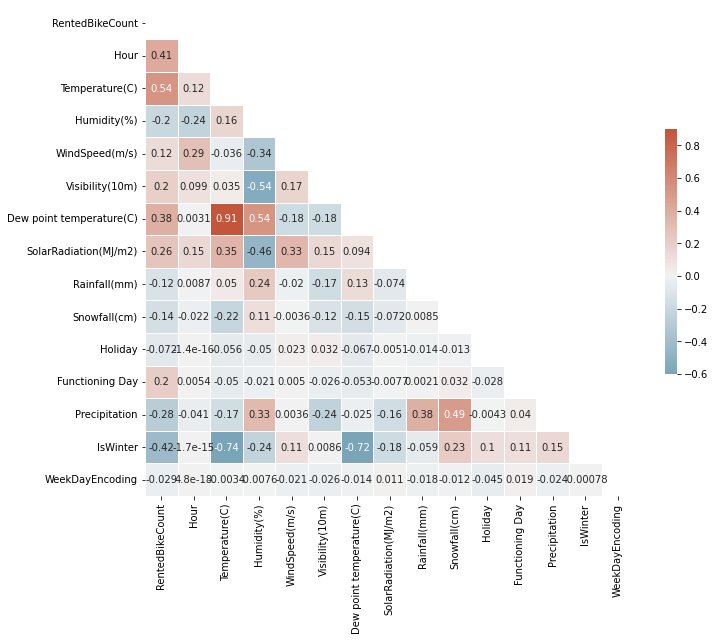

In [760]:
bikes_corr = bikes_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(bikes_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bikes_corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

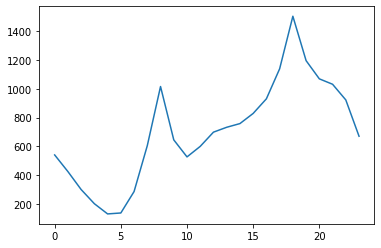

In [761]:
grouping = bikes_df[['Hour','RentedBikeCount']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['RentedBikeCount'])
plt.show()

There are a few different options for how we might want to hour variable. If the bike counts increased approximately linearly throughout the day, we might argue that the hour is ordinal and code it as an int in our model. However, the bike counts go up and down throughout the day, so it might be better to set it as a categorical variable.


In [762]:
bikes_df['Hour'] = bikes_df['Hour'].astype(object)

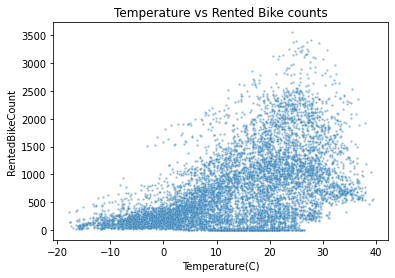

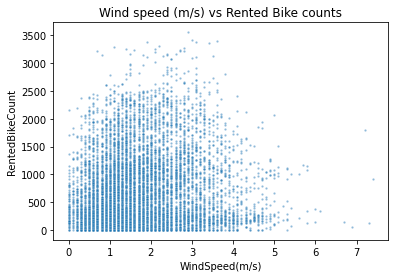

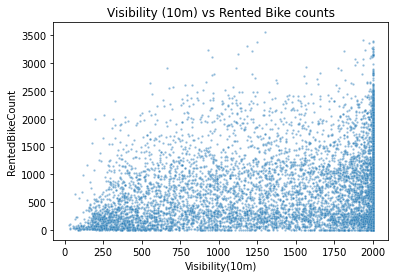

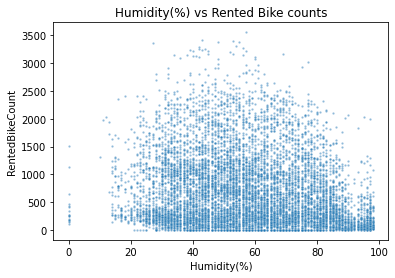

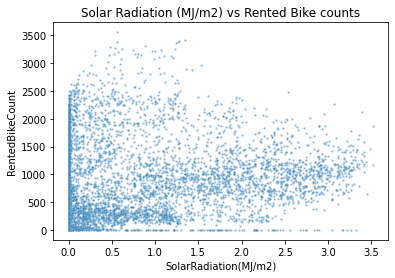

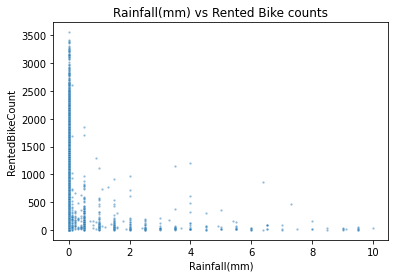

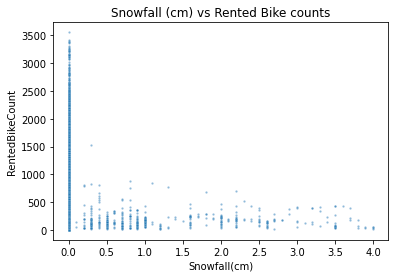

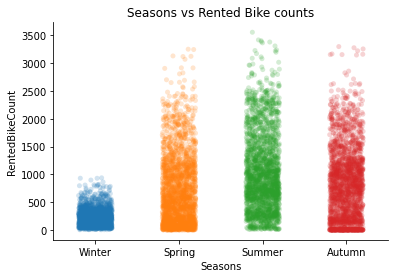

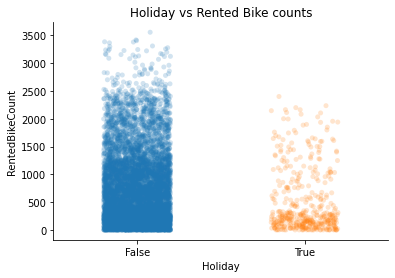

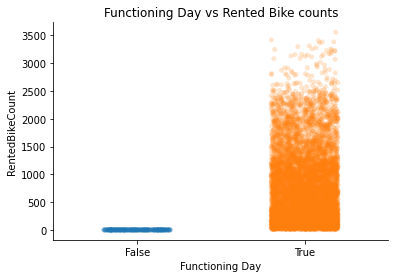

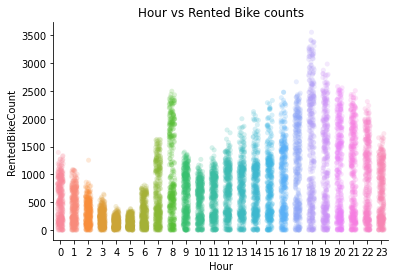

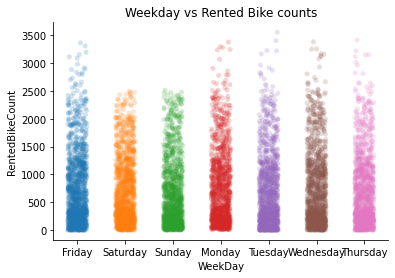

<Figure size 432x288 with 0 Axes>

In [763]:
sns.scatterplot(x=bikes_df['Temperature(C)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Temperature vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['WindSpeed(m/s)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Wind speed (m/s) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Visibility(10m)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Visibility (10m) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Humidity(%)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Humidity(%) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['SolarRadiation(MJ/m2)'], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Solar Radiation (MJ/m2) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Rainfall(mm)'][bikes_df['Rainfall(mm)'] <= 10], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Rainfall(mm) vs Rented Bike counts')
plt.show()
plt.clf()

sns.scatterplot(x=bikes_df['Snowfall(cm)'][bikes_df['Snowfall(cm)'] <= 4], y=bikes_df['RentedBikeCount'], s = 5, alpha=0.5)
plt.title('Snowfall (cm) vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='Seasons', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Seasons vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='Holiday', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Holiday vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='Functioning Day', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Functioning Day vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='Hour', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Hour vs Rented Bike counts')
plt.show()
plt.clf()

sns.stripplot(x='WeekDay', y='RentedBikeCount', data=bikes_df, jitter=0.2, alpha=0.2)
sns.despine()
plt.title('Weekday vs Rented Bike counts')
plt.show()
plt.clf()

Based on the correlation matrix and the scatter plots, it seems the linear relationship between the rented bike counts and other variables is poor to moderate. This potentially violates the first assumption of linear regression model.

# Machine Learning

## Feature Engineering

In [764]:
le = LabelEncoder()

#creating a copy of the DataFrame for further processing with only Functioning Days taken into consideration
bikes_df_testing = bikes_df[bikes_df['Functioning Day'] == True]
#bikes_df_testing = bikes_df.drop(columns=['Functioning Day'])

#creating one-hot-encoded data for categorical data
season_ohe = pd.get_dummies(bikes_df_testing.Seasons, drop_first=True)
weekday_ohe = pd.get_dummies(bikes_df_testing.WeekDay, drop_first=True)
bikes_df_testing = bikes_df_testing.join(season_ohe)
bikes_df_testing = bikes_df_testing.join(weekday_ohe)

bikes_df_testing['Month'] = le.fit_transform(bikes_df_testing['Month'])
bikes_df_testing['Holiday'] = le.fit_transform(bikes_df_testing['Holiday'])
bikes_df_testing['Hour'] = le.fit_transform(bikes_df_testing['Hour'])
#checking columns
print(bikes_df_testing.columns)




Index(['Date', 'RentedBikeCount', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'WindSpeed(m/s)', 'Visibility(10m)', 'Dew point temperature(C)',
       'SolarRadiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Precipitation', 'IsWinter', 'Month',
       'WeekDay', 'WeekDayEncoding', 'Spring', 'Summer', 'Winter', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


In [765]:
bikes_df_testing.head()

,Date,RentedBikeCount,Hour,Temperature(C),Humidity(%),WindSpeed(m/s),Visibility(10m),Dew point temperature(C),SolarRadiation(MJ/m2),Rainfall(mm),...,WeekDayEncoding,Spring,Summer,Winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,5,0,0,1,0,0,0,0,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,5,0,0,1,0,0,0,0,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,5,0,0,1,0,0,0,0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,5,0,0,1,0,0,0,0,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,5,0,0,1,0,0,0,0,0,0


We measured linear correlation between features. With mutual_info_regression method we can check other types of correlation.

In [766]:
#selecting features
#removing obsolete features
#Snowfall and Rainfall columns are now obsolete due to Precipitation feature
#removing also Seasons and Dew point tempterature as they are correlated to other features (Month and Temperature respectively)
X = bikes_df_testing.drop(columns = ['RentedBikeCount', 'Date','WeekDay','WeekDayEncoding','Precipitation', 'Seasons', 'Dew point temperature(C)', 'IsWinter'])
#encoding categorical features




Y = bikes_df_testing['RentedBikeCount']


In [767]:
#making sure all features are numerical
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hour                   8465 non-null   int32  
 1   Temperature(C)         8465 non-null   float64
 2   Humidity(%)            8465 non-null   int64  
 3   WindSpeed(m/s)         8465 non-null   float64
 4   Visibility(10m)        8465 non-null   int64  
 5   SolarRadiation(MJ/m2)  8465 non-null   float64
 6   Rainfall(mm)           8465 non-null   float64
 7   Snowfall(cm)           8465 non-null   float64
 8   Holiday                8465 non-null   int64  
 9   Functioning Day        8465 non-null   bool   
 10  Month                  8465 non-null   int32  
 11  Spring                 8465 non-null   uint8  
 12  Summer                 8465 non-null   uint8  
 13  Winter                 8465 non-null   uint8  
 14  Monday                 8465 non-null   uint8  
 15  Satu

In [768]:
score_func = partial(mutual_info_regression, discrete_features=[0,8,9,10,11,12,13], random_state=68)

# Select top 4 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=14)

selection.fit_transform(X, Y)
scores = selection.scores_
columns = X.columns
X = X[X.columns[selection.get_support(indices=True)]]
feature_scores = dict(map(lambda i,j : (i,j) , columns,scores))
# feature_scores = np.array([X.columns, selection.scores_])
feature_scores = pd.DataFrame.from_dict(feature_scores, orient='index').reset_index()
feature_scores.rename(inplace=True, columns={'index':'Feature',0:'Score'})
feature_scores = feature_scores.sort_values(by=['Score'],ascending=False)
# feature_scores = pd.melt(feature_scores, id_vars = )
# pd.melt(df,
#                   id_vars=["location", "name"], 
#                   var_name="Date",
#                   value_name="Value")
feature_scores

,Feature,Score
1,Temperature(C),0.379192
0,Hour,0.368778
10,Month,0.286995
13,Winter,0.198628
5,SolarRadiation(MJ/m2),0.191197
2,Humidity(%),0.111337
6,Rainfall(mm),0.079162
4,Visibility(10m),0.056655
12,Summer,0.055443
7,Snowfall(cm),0.049446


Using filter methods for feature selection, we selected the following four features for the model: Hour, Temperature, Month and Solar Radiation. Time to normalize the data.

In [769]:
#features = X.drop(columns=['Spring','Holiday','WindSpeed(m/s)'])

In [770]:
features = X
scaler = MinMaxScaler()
scaled = scaler.fit(features)
X = scaled.transform(features)
X = pd.DataFrame(X, columns=features.columns)

## Model


LR assumptions: https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html
Linearity: The relationship between X and the mean of Y is linear.
Homoscedasticity: The variance of residual is the same for any value of X.
Independence: Observations are independent of each other.
Normality: For any fixed value of X, Y is normally distributed.

In [771]:
#searching for the best alpha paramater for Lasso regularization
alpha_array = np.logspace(-1, 2, 100)
tuned_parameters = [{'alpha': alpha_array}]
model = GridSearchCV(estimator = Lasso(max_iter=2000), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
model.fit(X, Y)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']
lasso_best_alpha = model.best_params_['alpha']

print(model.best_params_, model.best_score_)

{'alpha': 5.722367659350217} -372.02502223656853


In [772]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hour                   8465 non-null   float64
 1   Temperature(C)         8465 non-null   float64
 2   Humidity(%)            8465 non-null   float64
 3   WindSpeed(m/s)         8465 non-null   float64
 4   Visibility(10m)        8465 non-null   float64
 5   SolarRadiation(MJ/m2)  8465 non-null   float64
 6   Rainfall(mm)           8465 non-null   float64
 7   Snowfall(cm)           8465 non-null   float64
 8   Holiday                8465 non-null   float64
 9   Month                  8465 non-null   float64
 10  Summer                 8465 non-null   float64
 11  Winter                 8465 non-null   float64
 12  Saturday               8465 non-null   float64
 13  Sunday                 8465 non-null   float64
dtypes: float64(14)
memory usage: 926.0 KB


C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Rogo\miniconda3\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


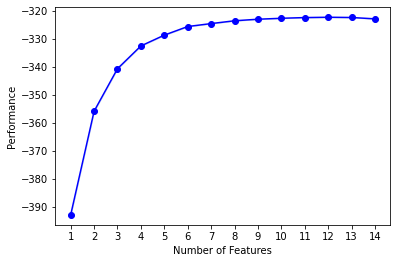

In [773]:
#determining the best number of features for linear regression
lr = LinearRegression()
sfs = SFS(lr,
          k_features=1,
          forward=False,
          floating=True,
          scoring='neg_mean_absolute_error',
          cv=0)
sfs.fit(X, Y)

# # Print the chosen feature names
# print(sfs.subsets_[35]['feature_names'])
# # Print the accuracy of the model after sequential forward selection
# print(sfs.subsets_[35]['avg_score'])
# # Plot the model accuracy
plot_sfs(sfs.get_metric_dict())
plt.show()

In [774]:
sfs = SFS(lr,
          k_features=14,
          forward=False,
          floating=True,
          scoring='neg_mean_absolute_error',
          cv=0)
sfs.fit(X, Y)

# Print the chosen feature names
print(sfs.subsets_[14]['feature_names'])


('Hour', 'Temperature(C)', 'Humidity(%)', 'WindSpeed(m/s)', 'Visibility(10m)', 'SolarRadiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(cm)', 'Holiday', 'Month', 'Summer', 'Winter', 'Saturday', 'Sunday')


In [775]:
#selecting features
X = X[list(sfs.subsets_[14]['feature_names'])]

In [776]:
#creating train ,test and validation sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=6)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)
print(f'Size of the train set: {len(x_train)}')
print(f'Size of the test set: {len(x_test)}')
print(f'Size of the validation set: {len(x_val)}')

Size of the train set: 5417
Size of the test set: 1693
Size of the validation set: 1355


In [777]:
lasso = Lasso(alpha = lasso_best_alpha)
lasso.fit(x_train, y_train)

l1_pred_train = lasso.predict(x_train)
l1_mse_train = np.sqrt(np.mean((l1_pred_train - y_train)**2))
print("Lasso (L1) Training Error: ", l1_mse_train)

# 2. Calculate testing error
l1_pred_test = lasso.predict(x_test)
l1_mse_test = np.sqrt(np.mean((l1_pred_test - y_test)**2))
print(l1_mse_test)

Lasso (L1) Training Error:  440.96361450561864
444.1898323816018


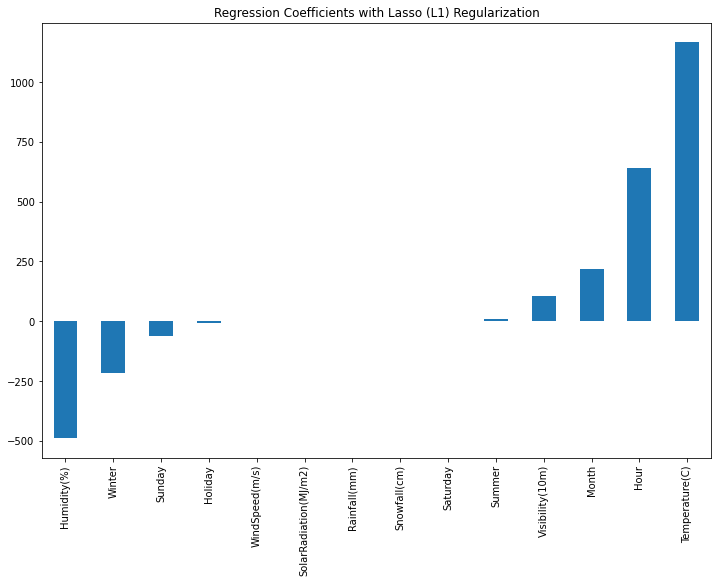

In [778]:
predictors = X.columns
coef = pd.Series(lasso.coef_,predictors).sort_values()
plt.figure(figsize = (12,8))
coef.plot(kind='bar', title='Regression Coefficients with Lasso (L1) Regularization')
plt.show()

In [779]:

mlr = LinearRegression()

mlr.fit(x_train, y_train)

y_predict = mlr.predict(x_test)


mlr_pred_train = mlr.predict(x_train)
mlr_mse_train = np.sqrt(np.mean((mlr_pred_train - y_train)**2))
print("mlr Training Error: ", mlr_mse_train)

# 2. Calculate testing error
mlr_pred_test = mlr.predict(x_test)
mlr_mse_test = np.sqrt(np.mean((mlr_pred_test - y_test)**2))
print(mlr_mse_test)


mlr Training Error:  427.3344500656301
432.18432571420584


In [780]:
mlr.score(x_train, y_train)

0.5521262734039794

In [781]:
mlr.score(x_test, y_test)

0.5553166909093701

In [782]:
# #testing linear regression on raw data (no feature selection, no standardization, no regularization)
# X2 = bikes_df.drop(columns=['RentedBikeCount','Date'])
# Y2 = bikes_df['RentedBikeCount']



# hours_ohe = pd.get_dummies(bikes_df.Hour, drop_first=True, prefix='h_')
# months_ohe = pd.get_dummies(bikes_df.Month, drop_first=True)
# season_ohe = pd.get_dummies(bikes_df.Seasons, drop_first=True)
# X2 = X2.join(hours_ohe)
# X2 = X2.join(months_ohe)
# X2 = X2.join(season_ohe)
# X2 = X2.drop(columns=['Hour', 'Month', 'Seasons'])

In [783]:
# x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, train_size = 0.8, test_size = 0.2, random_state=6)

In [784]:

# mlr = LinearRegression()

# mlr.fit(x_train2, y_train2)

# y_predict = mlr.predict(x_test2)


# mlr_pred_train = mlr.predict(x_train2)
# mlr_mse_train = np.sqrt(np.mean((mlr_pred_train - y_train2)**2))
# print("mlr Training Error: ", mlr_mse_train)

# # 2. Calculate testing error
# mlr_pred_test = mlr.predict(x_test2)
# mlr_mse_test = np.sqrt(np.mean((mlr_pred_test - y_test2)**2))
# print(mlr_mse_test)

As mentioned before, the linear relationship between the target variable and predictor variables is not very strong, which already violates the first assumption of the linear regression and may explain the poor scores of the linear regression model. Let's check whether a Decision Tree is better suited in this case.

## Decision Tree 

In [785]:
bikes_df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8465 non-null   datetime64[ns]
 1   RentedBikeCount           8465 non-null   int64         
 2   Hour                      8465 non-null   int32         
 3   Temperature(C)            8465 non-null   float64       
 4   Humidity(%)               8465 non-null   int64         
 5   WindSpeed(m/s)            8465 non-null   float64       
 6   Visibility(10m)           8465 non-null   int64         
 7   Dew point temperature(C)  8465 non-null   float64       
 8   SolarRadiation(MJ/m2)     8465 non-null   float64       
 9   Rainfall(mm)              8465 non-null   float64       
 10  Snowfall(cm)              8465 non-null   float64       
 11  Seasons                   8465 non-null   object        
 12  Holiday             

In [786]:
DT_X = bikes_df_testing.drop(columns=['RentedBikeCount', 'IsWinter', 'WeekDay','Seasons','Precipitation','Date','Visibility(10m)','Month'])
DT_Y = bikes_df_testing['RentedBikeCount']
x_train, x_test, y_train, y_test = train_test_split(DT_X, DT_Y, train_size = 0.8, test_size = 0.2, random_state=6)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)

In [687]:
max_depth_array = range(5,25)
ccp_array = np.logspace(-4,2,10)
min_samples_array=range(10,100, 10)
tuned_parameters = [{'max_depth': max_depth_array, 'ccp_alpha': ccp_array, 'min_samples_leaf':min_samples_array}]
model = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
model.fit(DT_X, DT_Y)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']
DT_best_depth = model.best_params_['max_depth']
DT_best_ccp = model.best_params_['ccp_alpha']
DT_best_minsamp = model.best_params_['min_samples_leaf']
print(model.best_params_, model.best_score_)

{'ccp_alpha': 0.01, 'max_depth': 12, 'min_samples_leaf': 20} -262.40553136904356


In [793]:
np.logspace(-4,2,10)

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [791]:
dt = DecisionTreeRegressor(min_samples_leaf = DT_best_minsamp, max_depth = DT_best_depth, ccp_alpha = DT_best_ccp)
dt.fit(x_train, y_train)


dt_pred_train = dt.predict(x_train)
dt_train_score = np.sqrt(np.mean((dt_pred_train - y_train)**2))
print("DT Training Error: ", dt_train_score)

# 2. Calculate testing error
dt_pred_test = dt.predict(x_test)
dt_test_score = np.sqrt(np.mean((dt_pred_test - y_test)**2))
print("DT Testing Error: ", dt_test_score)

print(dt.score(x_test, y_test))
print(dt.get_depth())

DT Training Error:  202.97192673413065
DT Testing Error:  251.5327687960844
0.8493733048141215
12


In [ ]:
bikes_df_testing.columns

In [ ]:
#2nd Tree with fewer features
DT_X = bikes_df_testing.drop(columns=['RentedBikeCount', 'WindSpeed(m/s)', 'Holiday','Visibility(10m)','Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep','IsWinter','Rainfall(mm)', 'Snowfall(cm)','Dew point temperature(C)'])
DT_Y = bikes_df_testing['RentedBikeCount']
x_train, x_test, y_train, y_test = train_test_split(DT_X, DT_Y, train_size = 0.8, test_size = 0.2, random_state=6)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)

In [ ]:
DT_X.columns

In [ ]:
max_depth_array = range(1,30)
ccp_array = np.logspace(-4,-1,20)
tuned_parameters = [{'max_depth': max_depth_array, 'ccp_alpha': ccp_array}]
model = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
model.fit(DT_X, DT_Y)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']
DT_best_depth = model.best_params_['max_depth']
DT_best_ccp = np.round(model.best_params_['ccp_alpha'])
print(model.best_params_, model.best_score_)

In [ ]:
dt = DecisionTreeRegressor(max_depth = DT_best_depth, ccp_alpha=DT_best_ccp)
dt.fit(x_train, y_train)


dt_pred_train = dt.predict(x_train)
dt_train_score = np.sqrt(np.mean((dt_pred_train - y_train)**2))
print("DT Training Error: ", dt_train_score)

# 2. Calculate testing error
dt_pred_test = dt.predict(x_test)
dt_test_score = np.sqrt(np.mean((dt_pred_test - y_test)**2))
print("DT Testing Error: ", dt_test_score)

print(dt.score(x_test, y_test))

In [ ]:
bikes_df.columns

In [ ]:
#3rd Tree with fewer features
DT_X = bikes_df[bikes_df['Functioning Day'] == True]
DT_X = bikes_df.drop(columns=['RentedBikeCount', 'Date','IsWinter','WindSpeed(m/s)', 'Holiday','Visibility(10m)','Rainfall(mm)', 'Snowfall(cm)','Dew point temperature(C)','Humidity(%)','Seasons','Functioning Day'])
DT_Y = bikes_df_testing['RentedBikeCount']
DT_X.columns
DT_X['Hour'] = le.fit_transform(DT_X['Hour'])
DT_X['Month'] = le.fit_transform(DT_X['Month'])
DT_X['Precipitation'] = le.fit_transform(DT_X['Precipitation'])
x_train, x_test, y_train, y_test = train_test_split(DT_X, DT_Y, train_size = 0.8, test_size = 0.2, random_state=6)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2, random_state=4)

In [ ]:
max_depth_array = range(1,30)
ccp_array = np.logspace(-4,-1,20)
tuned_parameters = [{'max_depth': max_depth_array, 'ccp_alpha': ccp_array}]
model = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = tuned_parameters, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
model.fit(DT_X, DT_Y)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']
DT_best_depth = model.best_params_['max_depth']
DT_best_ccp = np.round(model.best_params_['ccp_alpha'])
print(model.best_params_, model.best_score_)

In [ ]:
dt = DecisionTreeRegressor(max_depth = DT_best_depth, ccp_alpha=DT_best_ccp)
dt.fit(x_train, y_train)


dt_pred_train = dt.predict(x_train)
dt_train_score = np.sqrt(np.mean((dt_pred_train - y_train)**2))
print("DT Training Error: ", dt_train_score)

# 2. Calculate testing error
dt_pred_test = dt.predict(x_test)
dt_test_score = np.sqrt(np.mean((dt_pred_test - y_test)**2))
print("DT Testing Error: ", dt_test_score)
print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

# 